# Importando


In [1]:
import matplotlib.pyplot as plt
import pandas as pd   
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

def ColabOuCode(path_drive, path_local, ncolunas=None):
    '''
    Importa o DataFrame de acordo com a plataforma usada. Retorna um DataFrame.
    '''
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        df = pd.read_csv(path_drive)
    except:
        if ncolunas is None: df = pd.read_csv(path_local)
        else: df = pd.read_csv(path_local, nrows=ncolunas)
    return df

In [2]:
drive = '/content/drive/MyDrive/Colab Notebooks/TERA-desafio-3/data/dados_tratados.csv'
local = './data/dados_tratados.csv'

df = ColabOuCode(
    drive,
    local,
    ncolunas=None
)

df.shape    

(6362620, 12)

In [3]:
df.head()

,hora,type_label,nameOrig,oldbalanceOrig,origReinc,newbalanceOrig,nameDest,oldbalanceDest,destReinc,newbalanceDest,classAmount_label,isFraud
0,0,3,1231006815,12.044353,0,11.984780,1979787155,0.000000,0,0.0,2,1
1,0,3,1666544295,9.964065,0,9.872240,2044282225,0.000000,0,0.0,2,1
2,0,4,1305486145,5.198497,0,0.000000,553264065,0.000000,0,0.0,1,0
3,0,1,840083671,5.198497,0,0.000000,38997010,9.960907,0,0.0,1,0
4,0,3,2048537720,10.634749,0,10.305141,1230701703,0.000000,0,0.0,2,1


# Classificações

In [4]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Separando e balanceando os dados

In [5]:
%%time

from sklearn.model_selection import train_test_split

x_df = df.drop('isFraud',axis=1)
y_df = df[['isFraud']]

X_treino, X_teste, y_treino, y_teste = train_test_split(x_df, y_df, test_size=0.3, random_state=42)

CPU times: user 3.54 s, sys: 2.82 s, total: 6.35 s
Wall time: 6.34 s


In [6]:
%%time

from imblearn.combine import SMOTEENN

sennComb = SMOTEENN(
    sampling_strategy=0.2,
    random_state=42,
    n_jobs=-1
)

X_comb, y_comb = sennComb.fit_resample(X_treino, y_treino)


CPU times: user 6min 34s, sys: 39.7 s, total: 7min 14s
Wall time: 2min 53s


<AxesSubplot:xlabel='isFraud', ylabel='count'>

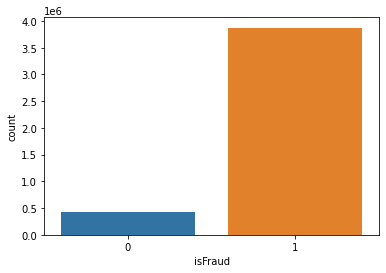

In [7]:
sns.countplot(y_comb['isFraud'])

## Decision Tree

In [8]:
%%time

from sklearn.tree import DecisionTreeClassifier

arvoreDecisao = DecisionTreeClassifier(
    max_depth=8
)
arvoreDecisao.fit(X_comb, y_comb)

y_arvPred = arvoreDecisao.predict(X_teste)

confusion_matrix(y_teste, y_arvPred)


CPU times: user 1min 28s, sys: 291 ms, total: 1min 29s
Wall time: 1min 29s


array([[   2126,     309],
       [   6261, 1900090]])

In [9]:
print(classification_report(y_teste, y_arvPred, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.25      0.87      0.39      2435
  Nao Fraude       1.00      1.00      1.00   1906351

    accuracy                           1.00   1908786
   macro avg       0.63      0.93      0.70   1908786
weighted avg       1.00      1.00      1.00   1908786



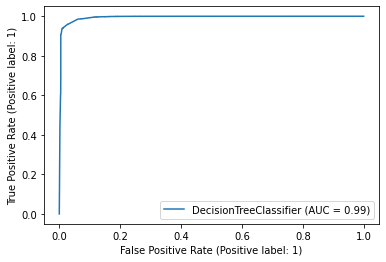

In [10]:
plot_roc_curve(arvoreDecisao, X_teste, y_teste,)
plt.show()

## Random Forest


In [11]:
%%time

from sklearn.ensemble import RandomForestClassifier

randForest = RandomForestClassifier(
    n_estimators=8,
    max_depth=13,
)

randForest.fit(X_comb, y_comb)

y_arvRandPred = randForest.predict(X_teste)

confusion_matrix(y_teste, y_arvRandPred)


CPU times: user 3min 32s, sys: 2.4 s, total: 3min 35s
Wall time: 3min 35s


array([[   2059,     376],
       [   2736, 1903615]])

In [12]:
print(classification_report(y_teste, y_arvRandPred, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.43      0.85      0.57      2435
  Nao Fraude       1.00      1.00      1.00   1906351

    accuracy                           1.00   1908786
   macro avg       0.71      0.92      0.78   1908786
weighted avg       1.00      1.00      1.00   1908786



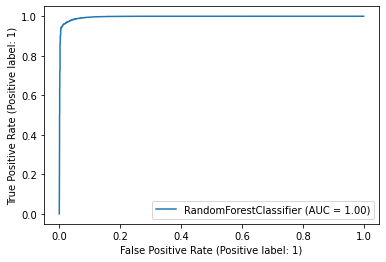

In [13]:
plot_roc_curve(randForest, X_teste, y_teste,)
plt.show()

## XGBoost Desbalanceado

In [17]:
%%time

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=15,
    max_depth=17,
    subsample=0.75,
    #gpu_id='0',
    #tree_method='gpu_hist'

)

xgb.fit(X_treino, y_treino) 
y_xgb = xgb.predict(X_teste)

confusion_matrix(y_teste, y_xgb)

[16:20:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 24min 25s, sys: 10 s, total: 24min 35s
Wall time: 7min 10s


array([[   1832,     603],
       [    117, 1906234]])

In [18]:
print(classification_report(y_teste, y_xgb, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.94      0.75      0.84      2435
  Nao Fraude       1.00      1.00      1.00   1906351

    accuracy                           1.00   1908786
   macro avg       0.97      0.88      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786



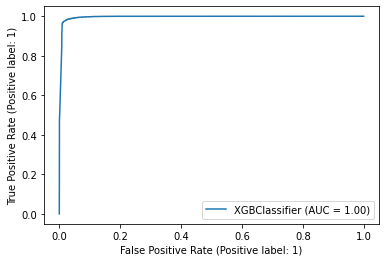

In [19]:
plot_roc_curve(xgb, X_teste, y_teste)

## XGBoost Balanceado

In [20]:
%%time

xgb = XGBClassifier(
    n_estimators=15,
    max_depth=17,
    subsample=0.75,
    #gpu_id='0',
    #tree_method='gpu_hist'

)

xgb.fit(X_comb, y_comb) 
y_xgb = xgb.predict(X_teste)

confusion_matrix(y_teste, y_xgb)

[16:27:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 27min 28s, sys: 8.18 s, total: 27min 36s
Wall time: 7min 49s


array([[   2075,     360],
       [   2025, 1904326]])

In [21]:
 print(classification_report(y_teste, y_xgb, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.51      0.85      0.64      2435
  Nao Fraude       1.00      1.00      1.00   1906351

    accuracy                           1.00   1908786
   macro avg       0.75      0.93      0.82   1908786
weighted avg       1.00      1.00      1.00   1908786



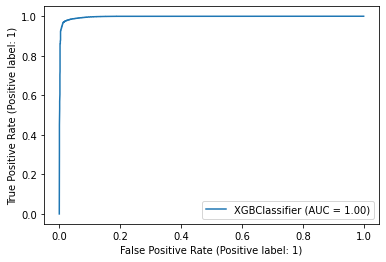

In [22]:
plot_roc_curve(xgb, X_teste, y_teste)
plt.show()